### Setup

In [1]:
import os, sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cobra')

from cobra import io, Model, Solution
from scripts.helpers.model import rxn_in_model, met_in_model, add_single_gene_reaction_pair
from scripts.opt._fba import flux_balance_analysis
from scripts.opt._fva import run_flux_variability_analysis

### Import Model & Preprocess

In [2]:
# Gap-filled model
model = io.read_sbml_model('../data/fill/xmls/MNL_iCre1355_auto_GAPFILL.xml')

# Add exchange reaction
ERG = "ergosterol_c"
ERGEXCH = "ERGOSTEROLEXCH"
if not rxn_in_model(model, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )

No objective coefficients in model. Unclear what should be optimized


### Medium

In [16]:
# Medium metabolites
medium_mets = ["h_e","h2o_e","pi_e","nh4_e","so4_e","fe2_e","mg2_e","na1_e","photonVis_e","o2_e","co2_e"] 
medium_rxns = ['CO2th'] # CO2 transport reaction to chloroplast is additionally to be inspected

for rxn in model.reactions:

    if 'e' in rxn.compartments:

        # Ignore if a medium met is not found in rxn
        if all((not met in [x.id for x in rxn.metabolites.keys()]) for met in medium_mets):
            continue

        mets = rxn.metabolites.items()
        rs = [f'{x[0].id} ({x[0].compartment})' for x in mets if x[1] < 0],
        ps = [f'{x[0].id} ({x[0].compartment})' for x in mets if x[1] > 0]

        # Ignore sink
        if len(rs) == 0 or len(ps) == 0:
            continue

        medium_rxns.append(rxn.id)

        print(f'{rxn.id} | {rxn.name}')
        print(f'\tR:{rs}')
        print(f'\tP:{ps}\n')

LIDOAMH | lidocaine amidohydrolase
	R:(['lido_e (e)', 'h2o_e (e)'],)
	P:['26dmani_e (e)', 'degly_e (e)', 'h_e (e)']

MEGLYXYLAMH | monoethylglycinexylidide amidohydrolase
	R:(['meglyxyl_e (e)', 'h2o_e (e)'],)
	P:['26dmani_e (e)', 'egly_e (e)', 'h_e (e)']

PRISM_solar_litho | spectral decomposition of solar light measured from Earth's surface
	R:(['photonVis_e (e)'],)
	P:['photon298_c (c)', 'photon437_u (u)', 'photon438_u (u)', 'photon450_h (h)', 'photon490_s (s)', 'photon646_h (h)', 'photon673_u (u)', 'photon680_u (u)']

PRISM_solar_exo | spectral decomposition of solar light measured from outer space
	R:(['photonVis_e (e)'],)
	P:['photon298_c (c)', 'photon437_u (u)', 'photon438_u (u)', 'photon450_h (h)', 'photon490_s (s)', 'photon646_h (h)', 'photon673_u (u)', 'photon680_u (u)']

PRISM_incandescent_60W | spectral decomposition of 60W incandescent light bulb
	R:(['photonVis_e (e)'],)
	P:['photon298_c (c)', 'photon437_u (u)', 'photon438_u (u)', 'photon450_h (h)', 'photon490_s (s)', 'pho

### Flux-Variability Analysis

In [17]:
fva = run_flux_variability_analysis(
    model,
    loopless=True,
    pfba_factor=None,
    objectives=[ERGEXCH],
    reactions=medium_rxns,
)

fva

,minimum,maximum
CO2th,0.000000e+00,7.760196e+01
LIDOAMH,0.000000e+00,0.000000e+00
MEGLYXYLAMH,0.000000e+00,0.000000e+00
PRISM_solar_litho,0.000000e+00,0.000000e+00
PRISM_solar_exo,0.000000e+00,0.000000e+00
PRISM_incandescent_60W,0.000000e+00,0.000000e+00
PRISM_fluorescent_warm_18W,0.000000e+00,0.000000e+00
PRISM_fluorescent_cool_215W,0.000000e+00,0.000000e+00
PRISM_metal_halide,0.000000e+00,0.000000e+00
PRISM_high_pressure_sodium,0.000000e+00,0.000000e+00


### Sensitivity Analysis

In [18]:
options = {
    'steps': 30,
    'significance': 0.0005
}

# Ensure there's a valid range to compute
valid_range = lambda x: fva.loc[x, 'maximum'] - fva.loc[x, 'minimum'] > options['significance']
valid_rxns = [rxn for rxn in medium_rxns if valid_range(rxn)]

# Get the range for each medium metabolite
medium_ranges = {met: (float(fva.loc[met, 'minimum']), float(fva.loc[met, 'maximum'])) for met in valid_rxns}

results = {}
for k, v in medium_ranges.items():

    print(f"Running S.A. on {k}")

    # Gradient list from minimum to maximum with 15 steps
    diff = v[1] - v[0]
    gradient = [v[0] + i * (diff / options['steps']) for i in range(options['steps'])]

    results[k] = {
        'gradient': gradient,
        'results': []
    }
    for idx, step in enumerate(gradient):
        print(f'\tStep {idx + 1}/{options["steps"]}. Value: {step:<.4f}')
        # Copy model
        temp = model.copy()
        # Set step bounds for k
        temp.reactions.get_by_id(k).lower_bound = step
        temp.reactions.get_by_id(k).upper_bound = step
        # Run FBA
        fba = flux_balance_analysis(
            temp,
            objectives=[ERGEXCH],
            loopless=False,
            is_pfba=True
        )
        results[k]['results'].append(fba)

Running S.A. on CO2th
	Step 1/30. Value: 0.0000
	Step 2/30. Value: 2.5867
	Step 3/30. Value: 5.1735
	Step 4/30. Value: 7.7602
	Step 5/30. Value: 10.3469
	Step 6/30. Value: 12.9337
	Step 7/30. Value: 15.5204
	Step 8/30. Value: 18.1071
	Step 9/30. Value: 20.6939
	Step 10/30. Value: 23.2806
	Step 11/30. Value: 25.8673
	Step 12/30. Value: 28.4541
	Step 13/30. Value: 31.0408
	Step 14/30. Value: 33.6275
	Step 15/30. Value: 36.2142
	Step 16/30. Value: 38.8010
	Step 17/30. Value: 41.3877
	Step 18/30. Value: 43.9744
	Step 19/30. Value: 46.5612
	Step 20/30. Value: 49.1479
	Step 21/30. Value: 51.7346
	Step 22/30. Value: 54.3214
	Step 23/30. Value: 56.9081
	Step 24/30. Value: 59.4948
	Step 25/30. Value: 62.0816
	Step 26/30. Value: 64.6683
	Step 27/30. Value: 67.2550
	Step 28/30. Value: 69.8418
	Step 29/30. Value: 72.4285
	Step 30/30. Value: 75.0152
Running S.A. on PRISM_design_growth
	Step 1/30. Value: 25.9735
	Step 2/30. Value: 27.7744
	Step 3/30. Value: 29.5753
	Step 4/30. Value: 31.3761
	Step 5

### Results

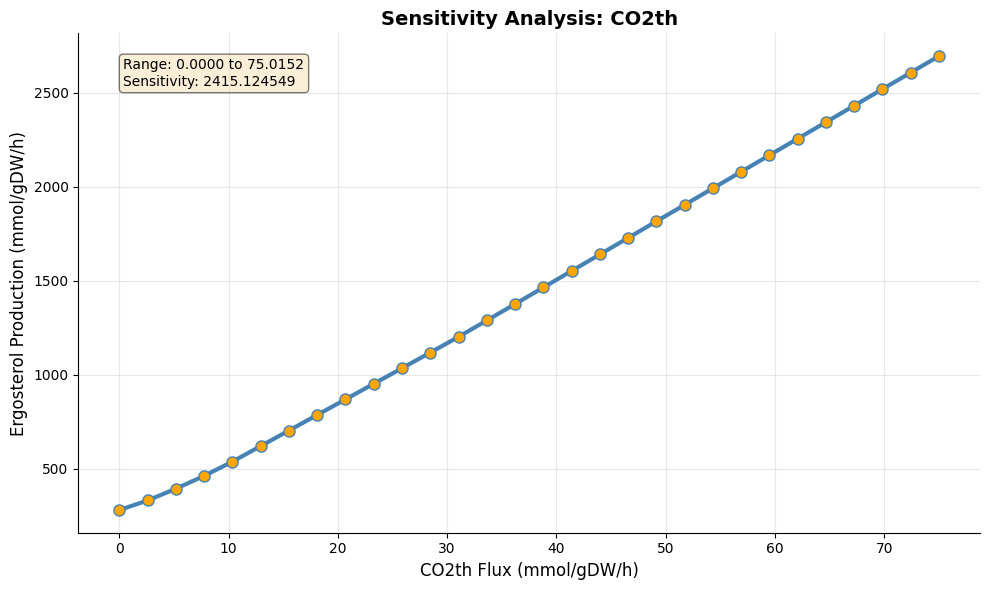

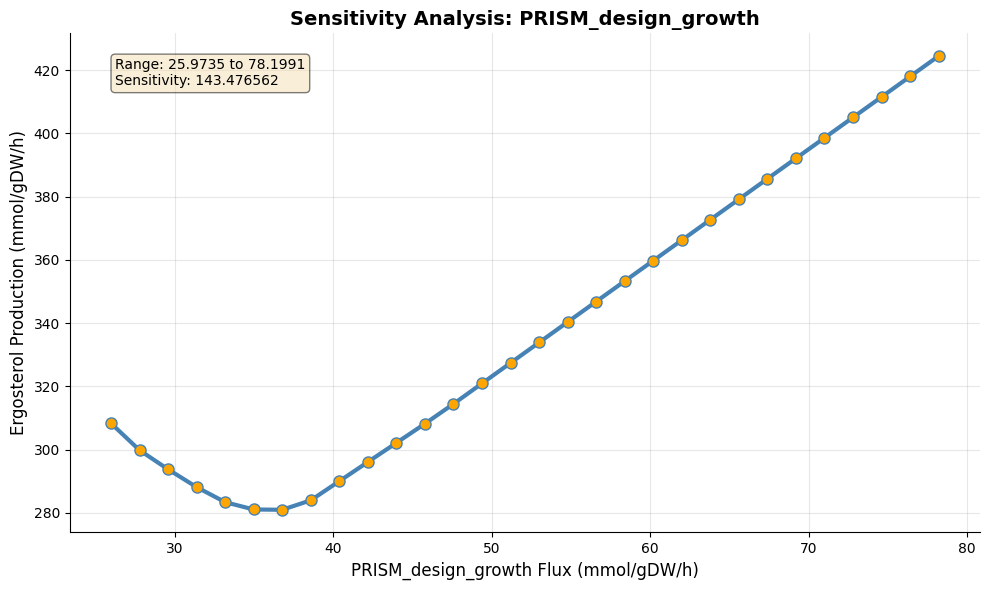

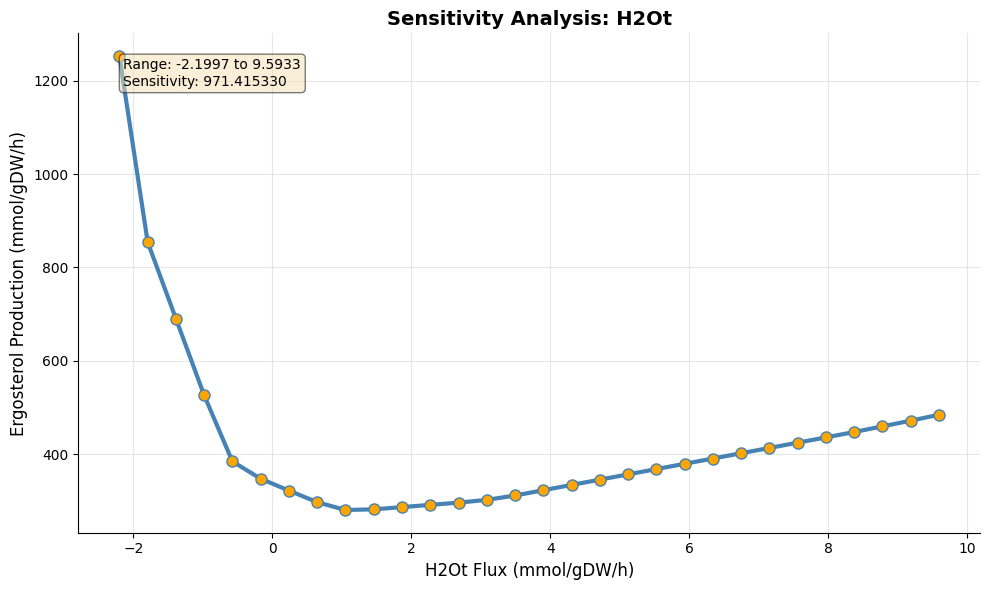

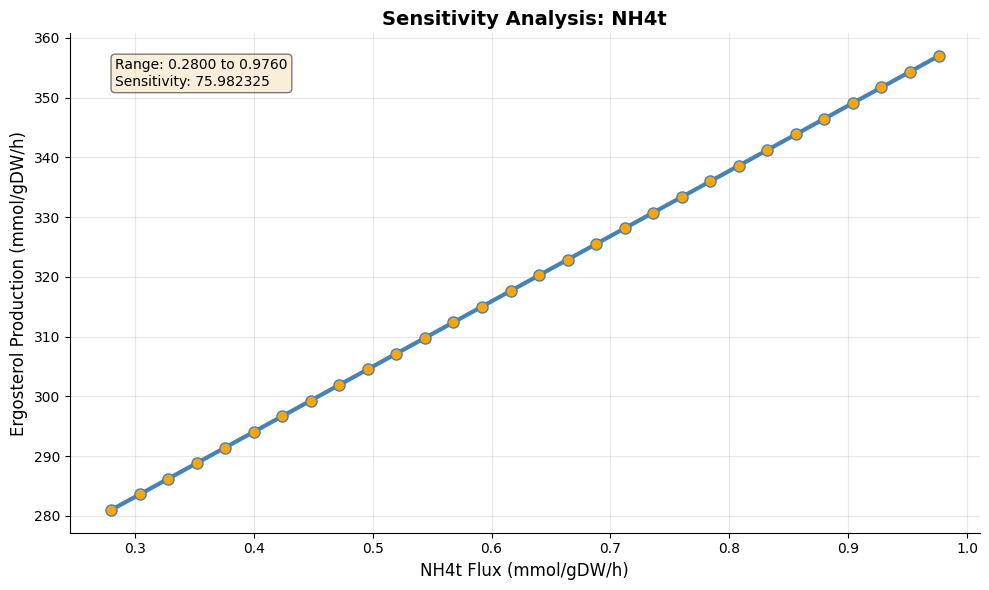

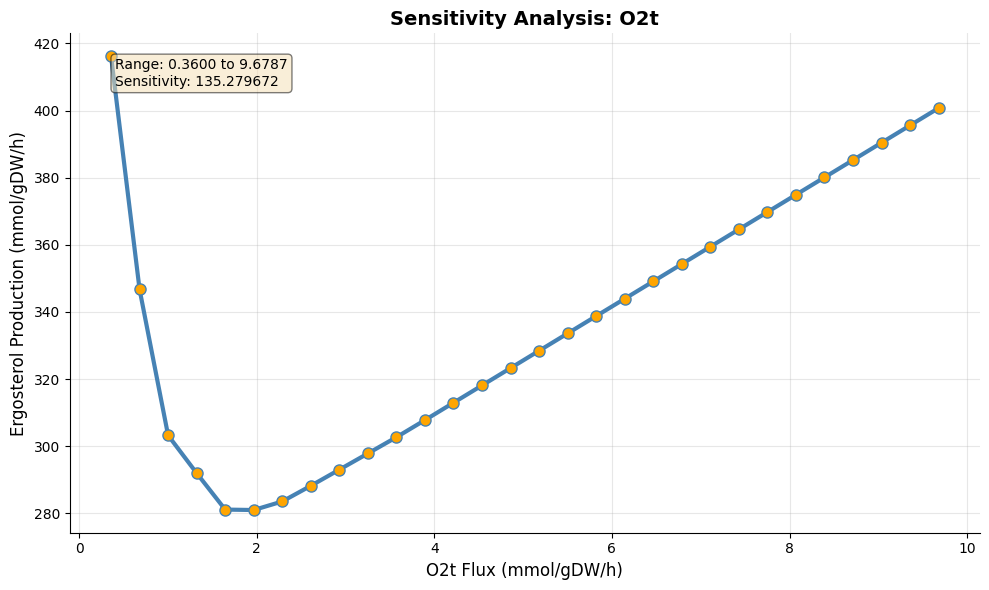

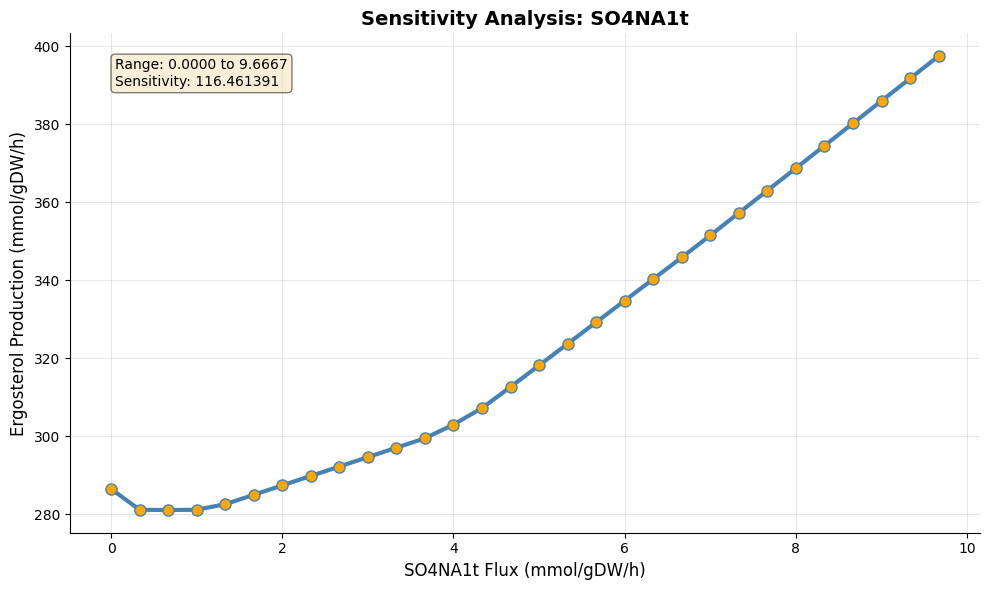

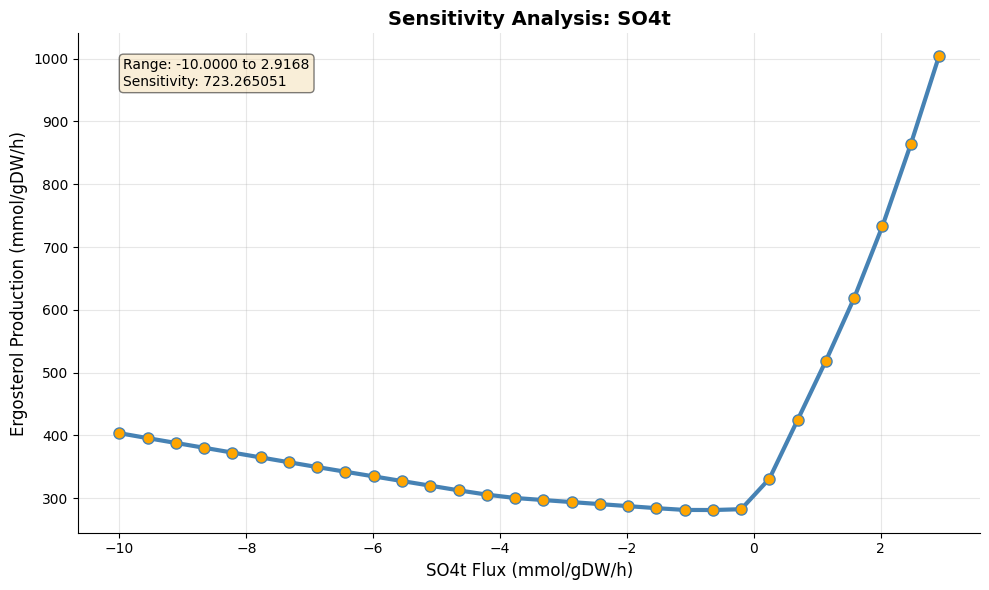

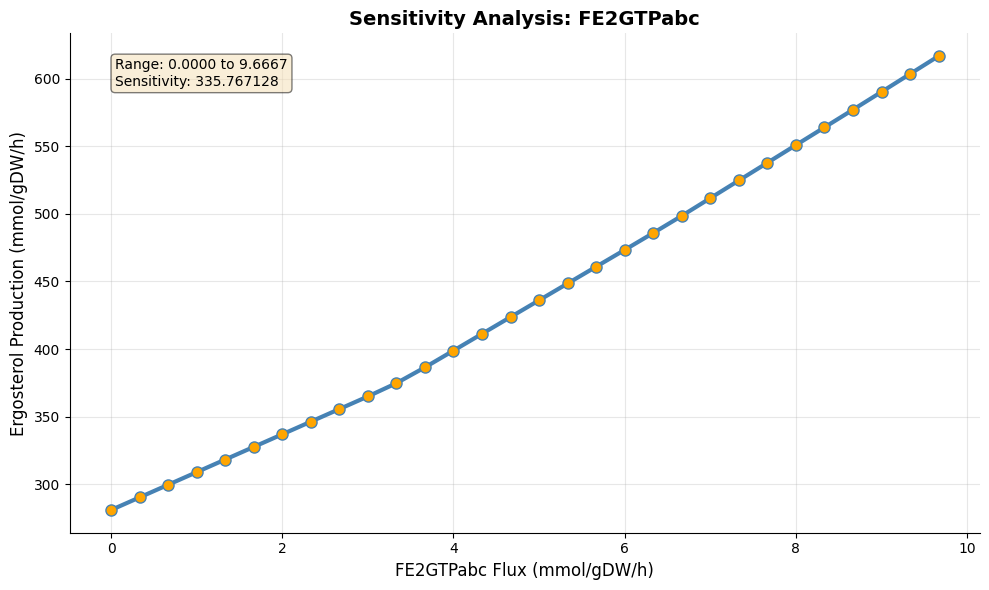

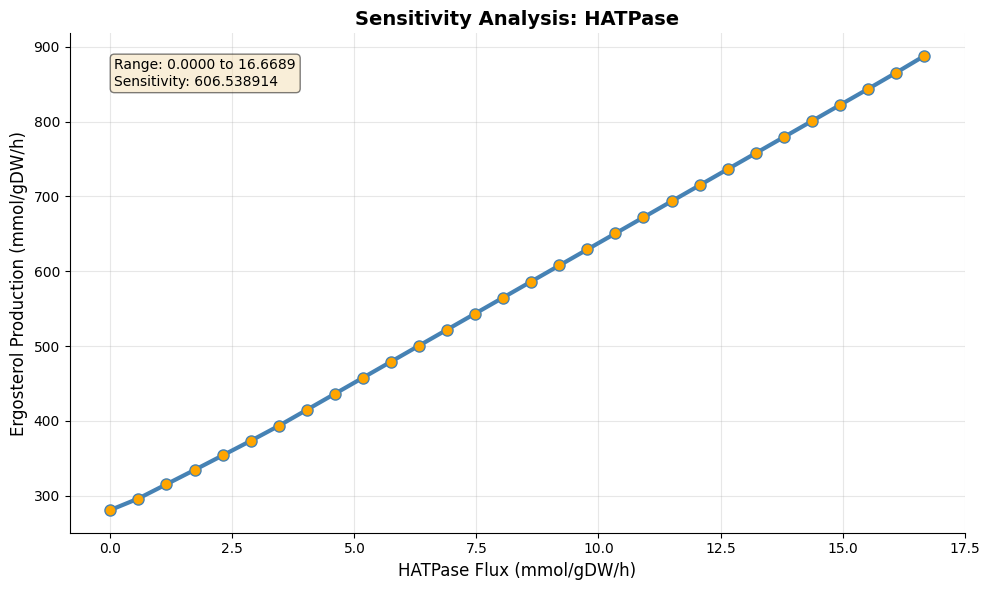

In [19]:
import matplotlib.pyplot as plt

# Individual plots for better visualization
for rxn_id, data in results.items():

    plt.figure(figsize=(10, 6))
    
    # Extract data
    gradient = data['gradient']
    objective_values = []
    
    for fba_result in data['results']:
        if fba_result is not None and hasattr(fba_result, 'objective_value'):
            objective_values.append(fba_result.objective_value)
        else:
            objective_values.append(0)
    
    # Create the plot
    plt.plot(
        gradient, objective_values, 'o-', linewidth=3, markersize=8, 
        color='steelblue', markerfacecolor='orange', markeredgecolor='steelblue'
    )
    
    # Styling
    plt.xlabel(f'{rxn_id} Flux (mmol/gDW/h)', fontsize=12)
    plt.ylabel('Ergosterol Production (mmol/gDW/h)', fontsize=12)
    plt.title(f'Sensitivity Analysis: {rxn_id}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add statistics text box
    min_obj = min(objective_values)
    max_obj = max(objective_values)
    sensitivity = max_obj - min_obj
    
    textstr = f'Range: {min(gradient):.4f} to {max(gradient):.4f}\nSensitivity: {sensitivity:.6f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join('..','results','bench','sensitivity')
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f'{rxn_id}.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

In [ ]:
# Testing for CO2 rates
# run_flux_variability_analysis(model, pfba_factor=None, objectives=['Biomass_Chlamy_auto'], reactions=['CO2t','EX_co2_e','CO2th'])